In [1]:
import numpy as np
import pylab as plt
from matplotlib import cm
from itertools import product
from time import perf_counter
import numexpr as ne
from PIL import Image

%matplotlib notebook

In [2]:
%load_ext line_profiler

In [3]:
def julia_iteration(z, c, maxiter=256):
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z**2 + c
    return n

def julia_set(w, h, c, maxiter=256):
    m = np.empty((h, w), dtype=np.uint8)
    for j, i in product(range(h), range(w)):
        z = (i-w/2)/(h/2) + (j-h/2)/(h/2)*1j
        m[j,i] = julia_iteration(z, c, maxiter)

    return m

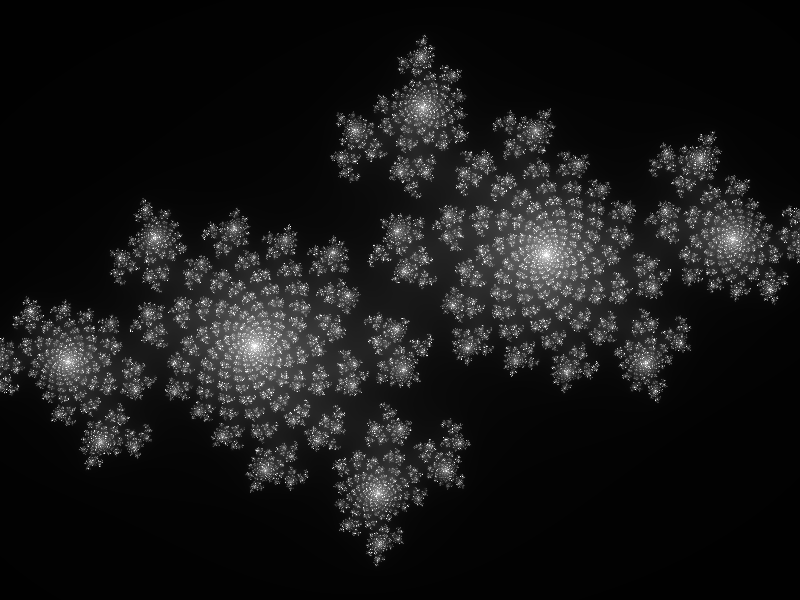

In [4]:
Image.fromarray(julia_set(800, 600, -0.7+0.3*1j))

In [5]:
%timeit julia_set(2000, 1200, -0.7+0.3*1j)

1 loop, best of 3: 12.9 s per loop


In [6]:
%lprun -f julia_set julia_set(2000, 1200, -0.7+0.3j, 1)

```
Timer unit: 1e-06 s

Total time: 12.1299 s
File: <ipython-input-4-5ad559df94c0>
Function: julia_set at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     8                                           def julia_set(w, h, c, maxiter=256):
     9         1           23     23.0      0.0      m = np.empty((h, w), dtype=np.uint8)
    10   2400001      1618908      0.7     13.3      for j, i in product(range(h), range(w)):
    11   2400000      2938588      1.2     24.2          z = (i-w/2)/(h/2) + (j-h/2)/(h/2)*1j
    12   2400000      7572399      3.2     62.4          m[j,i] = julia_iteration(z, c, maxiter)
    13                                           
    14         1            1      1.0      0.0      return m
```

In [10]:
def julia_set_block(w, h, c, maxiter=256):
    i0 = (np.arange(w)-w/2)/(h/2)
    j0 = (np.arange(h)-h/2)/(h/2)*1j
    z = j0.reshape(h,1) + i0.reshape(w)
    m = np.zeros((h, w), dtype=np.uint8)
    
    for n in range(maxiter):
        limit = np.abs(z) < 2
        mask = np.where(limit)
        zmasked = z[mask]
        z[mask] = zmasked**2 + c
        m[mask] = n
    
    return m

In [11]:
%timeit julia_set_block(2000, 1200, -0.7 + 0.3*1j)

1 loop, best of 3: 11.7 s per loop


In [12]:
%lprun -f julia_set_block julia_set_block(2000, 1200, -0.7+0.3j, 1)

```
Timer unit: 1e-06 s

Total time: 0.233557 s
File: <ipython-input-17-cf620e8196a2>
Function: julia_set_block at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def julia_set_block(w, h, c, maxiter=256):
     2         1          606    606.0      0.3      i0 = (np.arange(w)-w/2)/(h/2)
     3         1         2496   2496.0      1.1      j0 = (np.arange(h)-h/2)/(h/2)*1j
     4         1        25913  25913.0     11.1      z = j0.reshape(h,1) + i0.reshape(w)
     5         1          389    389.0      0.2      m = np.zeros((h, w), dtype=np.uint8)
     6                                               
     7         2           17      8.5      0.0      for n in range(maxiter):
     8         1        75377  75377.0     32.3          limit = np.abs(z) < 2
     9         1        36664  36664.0     15.7          mask = np.where(limit)
    10         1        32023  32023.0     13.7          zmasked = z[mask]
    11         1        42812  42812.0     18.3          z[mask] = ne.evaluate('zmasked**2 + c')
    12         1        17259  17259.0      7.4          m[mask] = n
    13                                               
    14         1            1      1.0      0.0      return m
```

In [13]:
def julia_set_block_fast(w, h, c, maxiter=256):
    i0 = (np.arange(w)-w/2)/(h/2)
    j0 = (np.arange(h)-h/2)/(h/2)*1j
    z = j0.reshape(h,1) + i0.reshape(w)
    m = np.zeros((h, w), dtype=np.uint8)
    
    for n in range(maxiter):
        limit = ne.evaluate('z.real**2 + z.imag**2 < 2')
        mask = np.where(limit)
        zmasked = z[mask]
        z[mask] = ne.evaluate('zmasked**2 + c')
        m[mask] = n
    
    return m

In [14]:
%lprun -f julia_set_block_fast julia_set_block_fast(2000, 1200, -0.7+0.3j, 1)

```
Timer unit: 1e-06 s

Total time: 0.134816 s
File: <ipython-input-23-9252d90c43c7>
Function: julia_set_block_fast at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def julia_set_block_fast(w, h, c, maxiter=256):
     2         1          892    892.0      0.7      i0 = (np.arange(w)-w/2)/(h/2)
     3         1           98     98.0      0.1      j0 = (np.arange(h)-h/2)/(h/2)*1j
     4         1        23522  23522.0     17.4      z = j0.reshape(h,1) + i0.reshape(w)
     5         1          368    368.0      0.3      m = np.zeros((h, w), dtype=np.uint8)
     6                                               
     7         2           16      8.0      0.0      for n in range(maxiter):
     8         1         9364   9364.0      6.9          limit = ne.evaluate('z.real**2 + z.imag**2 < 2')
     9         1        28749  28749.0     21.3          mask = np.where(limit)
    10         1        28019  28019.0     20.8          zmasked = z[mask]
    11         1        32100  32100.0     23.8          z[mask] = ne.evaluate('zmasked**2 + c')
    12         1        11687  11687.0      8.7          m[mask] = n
    13                                               
    14         1            1      1.0      0.0      return m
```

In [15]:
%timeit julia_set_block_fast(2000, 1200, -0.7 + 0.3*1j)

1 loop, best of 3: 4.78 s per loop


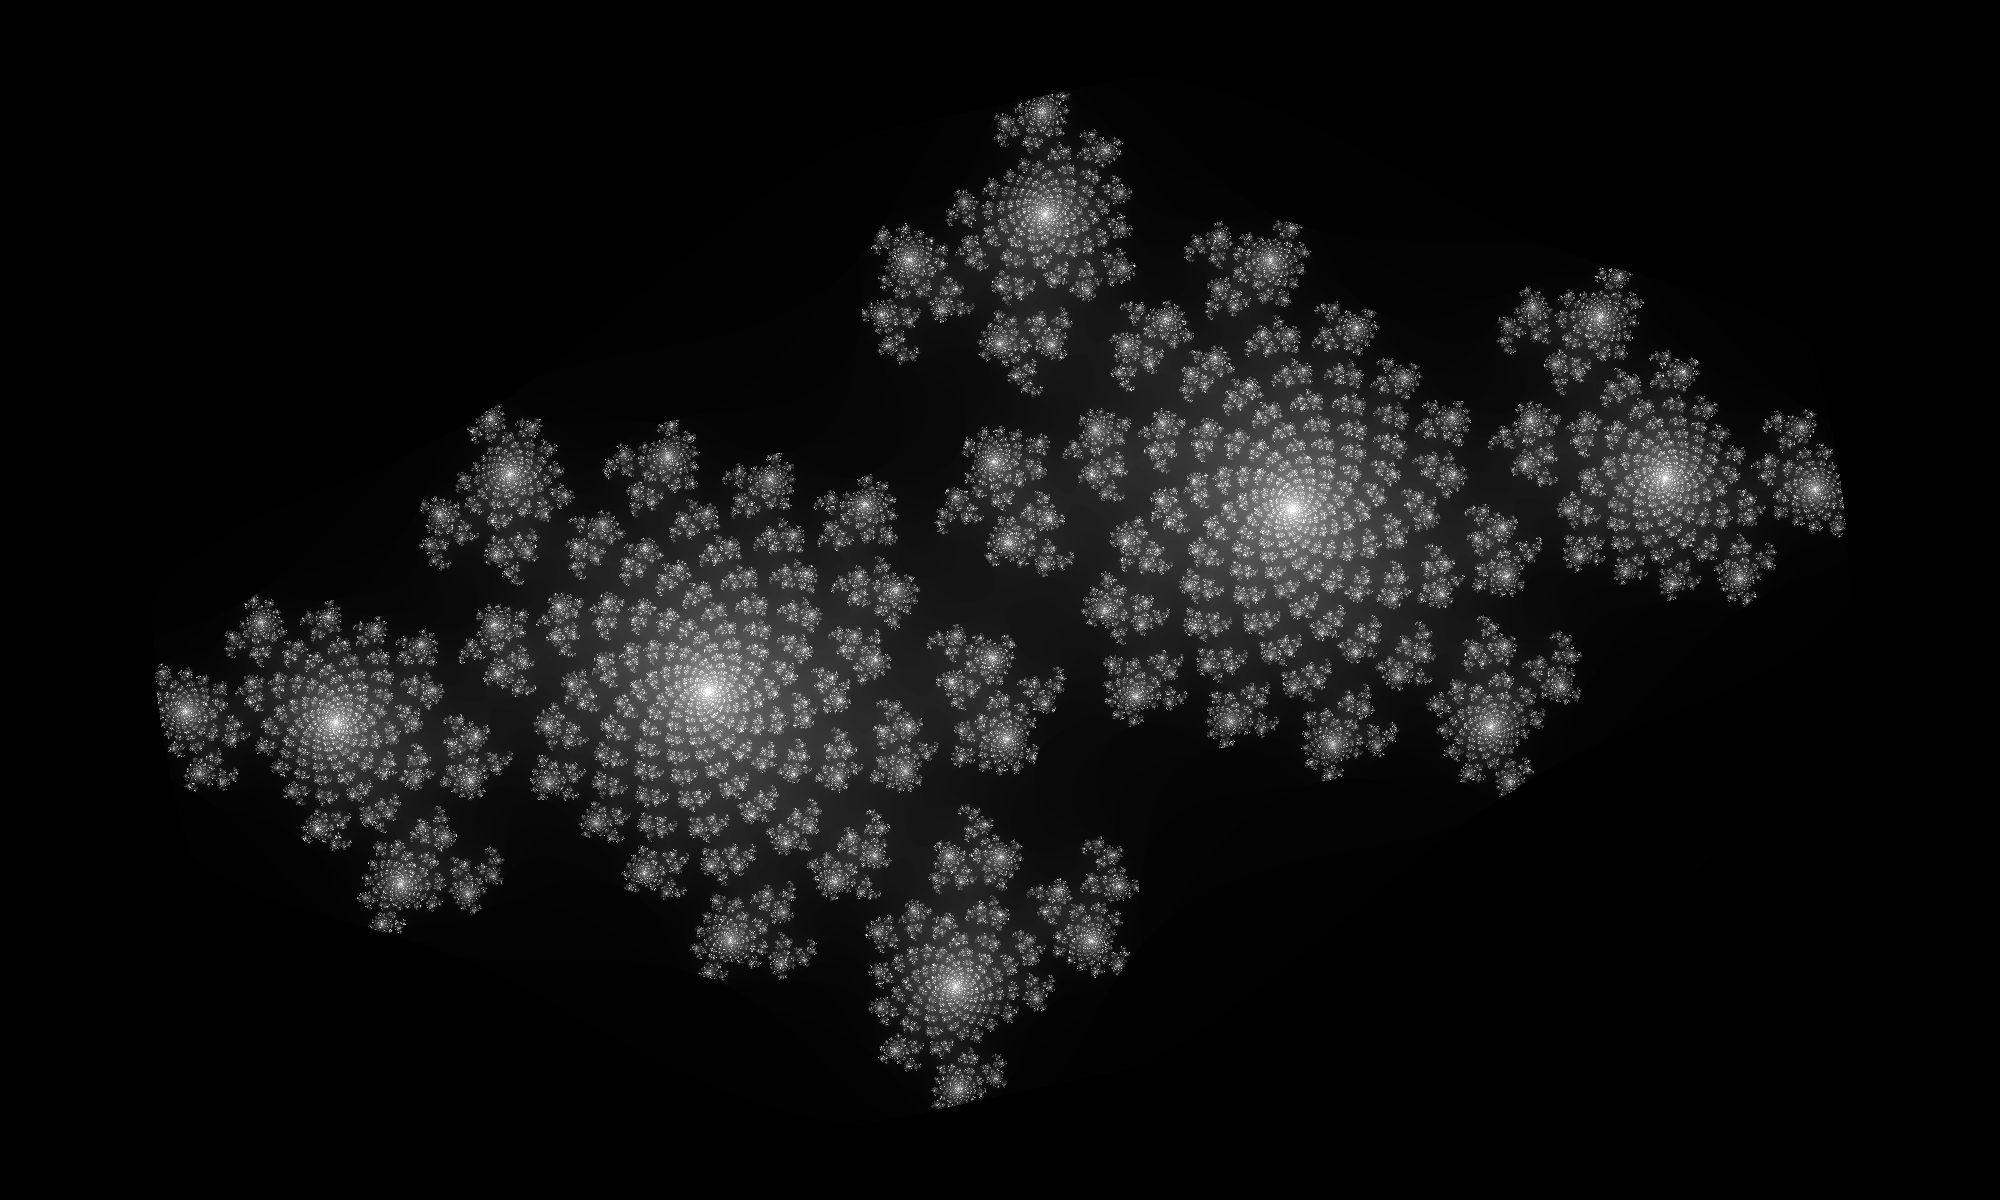

In [16]:
Image.fromarray(julia_set_block_fast(2000, 1200, -0.7 + 0.3*1j))

In [17]:
%load_ext Cython

In [21]:
%%cython -a

import cython
import numpy as np
cimport numpy as np
#from std_complex cimport cabs

cdef np.uint8_t julia_iteration(double complex z, double complex c, int maxiter=256) nogil:
    cdef np.uint8_t n
    for n in range(maxiter):
        if z.real**2 + z.imag**2 > 2.0:  #abs(z)
            return n
        z = z**2 + c
    return n


@cython.boundscheck(False)
cpdef np.ndarray[np.uint8_t, ndim=2] julia_set_cython(int w, int h, double complex c, int maxiter=256):
    cdef int i, j, n
    cdef double complex z
    marr = np.empty((h, w), dtype=np.uint8)
    cdef np.uint8_t [:,:] m = marr
    
    for j in range(h):
        for i in range(w):
            z = (i-w/2)/(h/2) + (j-h/2)/(h/2)*1j
            m[j,i] = julia_iteration(z, c, maxiter)
                
    return np.asarray(m)

In [16]:
m = julia_set_cython(2000, 1200, -0.7 + 0.3*1j, 256)

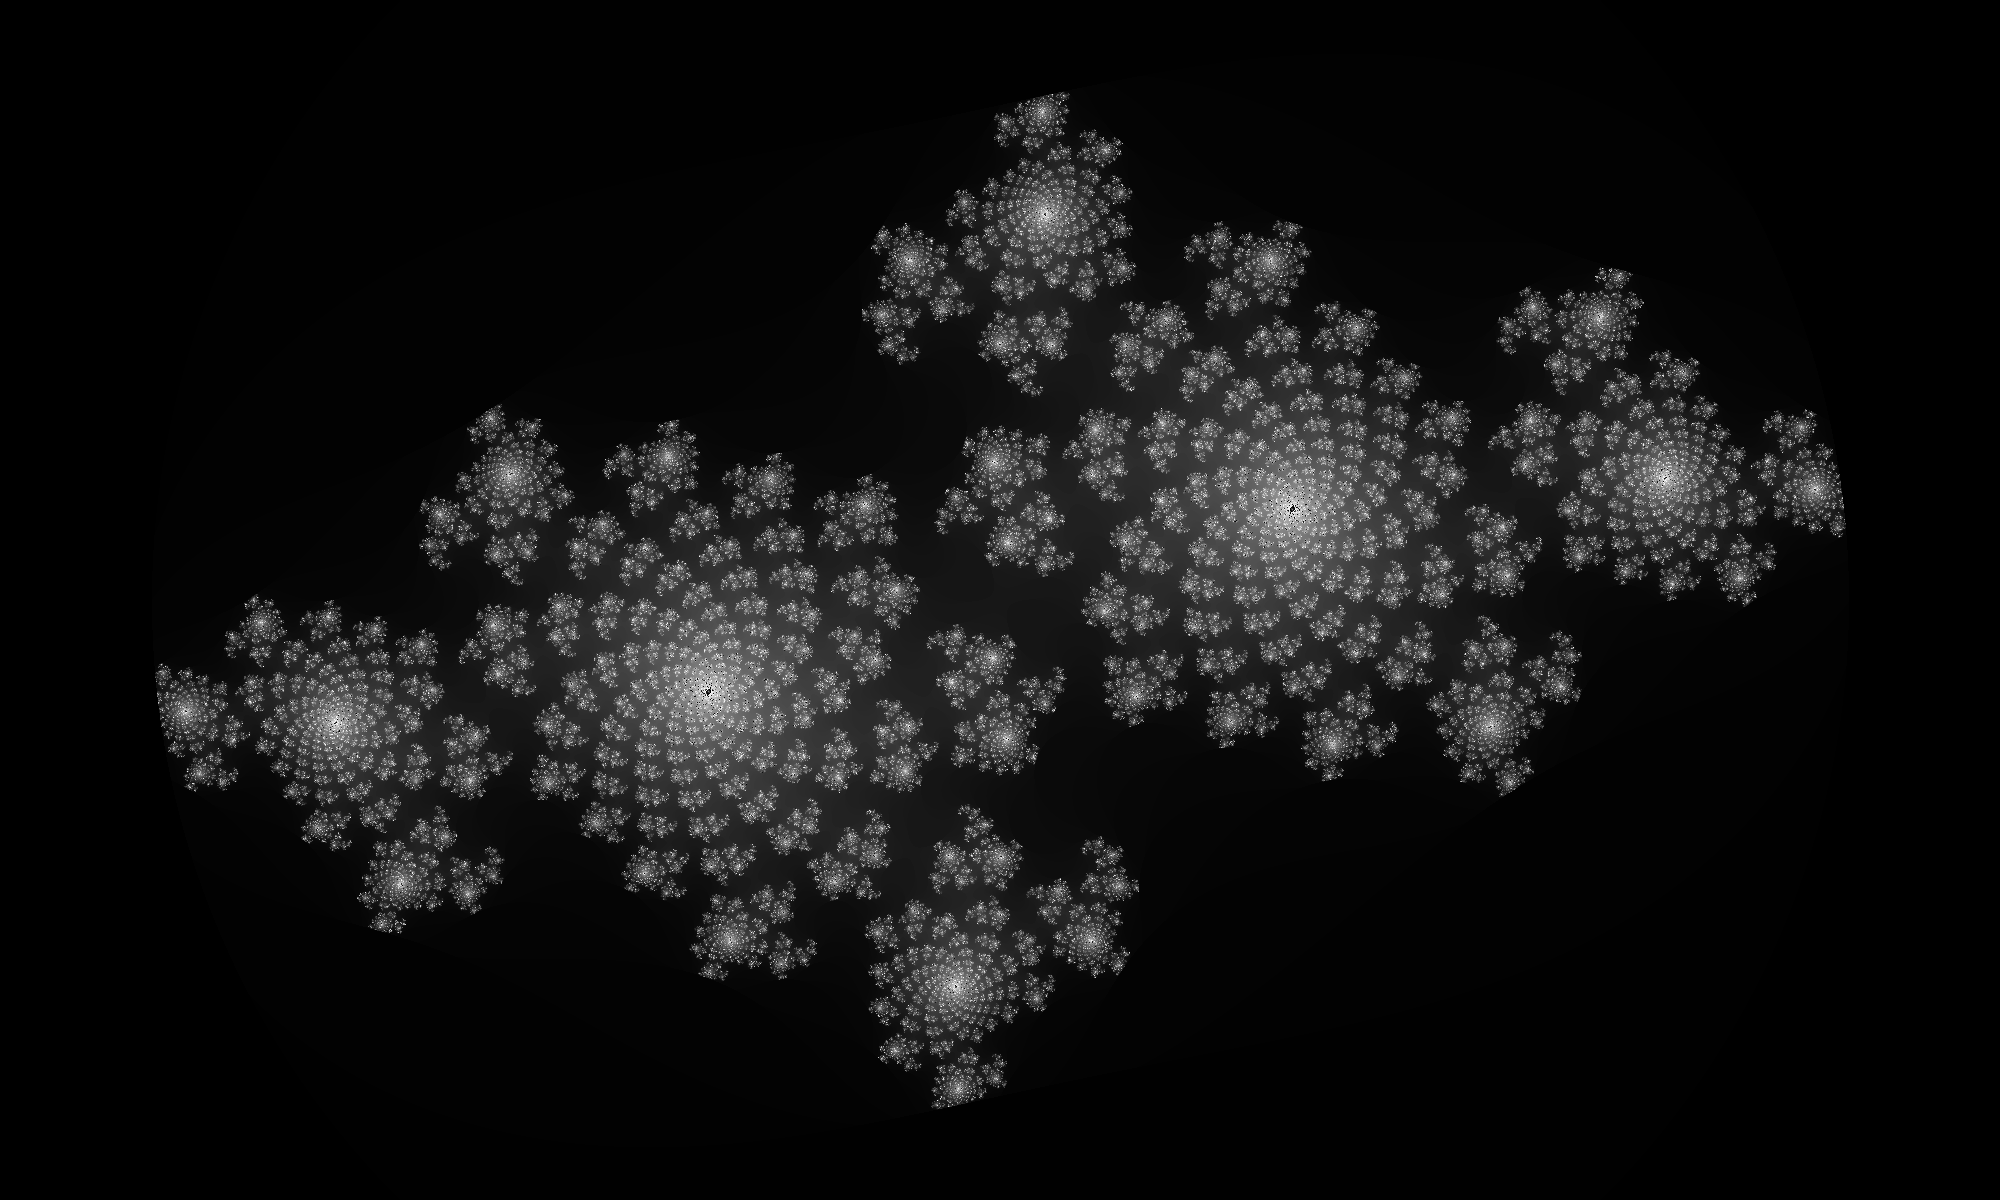

In [17]:
Image.fromarray(m)

In [18]:
%timeit julia_set_cython(2000, 1200, -0.7 + 0.3*1j, 256)

1 loop, best of 3: 229 ms per loop


In [19]:
import numba

In [20]:
@numba.jit(numba.uint8[:,:](numba.int64, numba.int64, numba.complex128, numba.int64))
def julia_set_numba_fast(w, h, c, maxiter=256):
    m = np.zeros((h, w), dtype=np.uint8)
    creal = c.real
    cimag = c.imag
    
    for j in range(h):
        for i in range(w):
            z = (i-w/2)/(h/2) + (j-h/2)/(h/2)*1j
            
            for n in range(maxiter):
                if z.real**2 + z.imag**2 > 2:
                    m[j,i] = n
                    break
                else:
                    z = z**2 + c
    return m

In [21]:
m = julia_set_numba_fast(2000, 1200, -0.7 + 0.3*1j, 256)

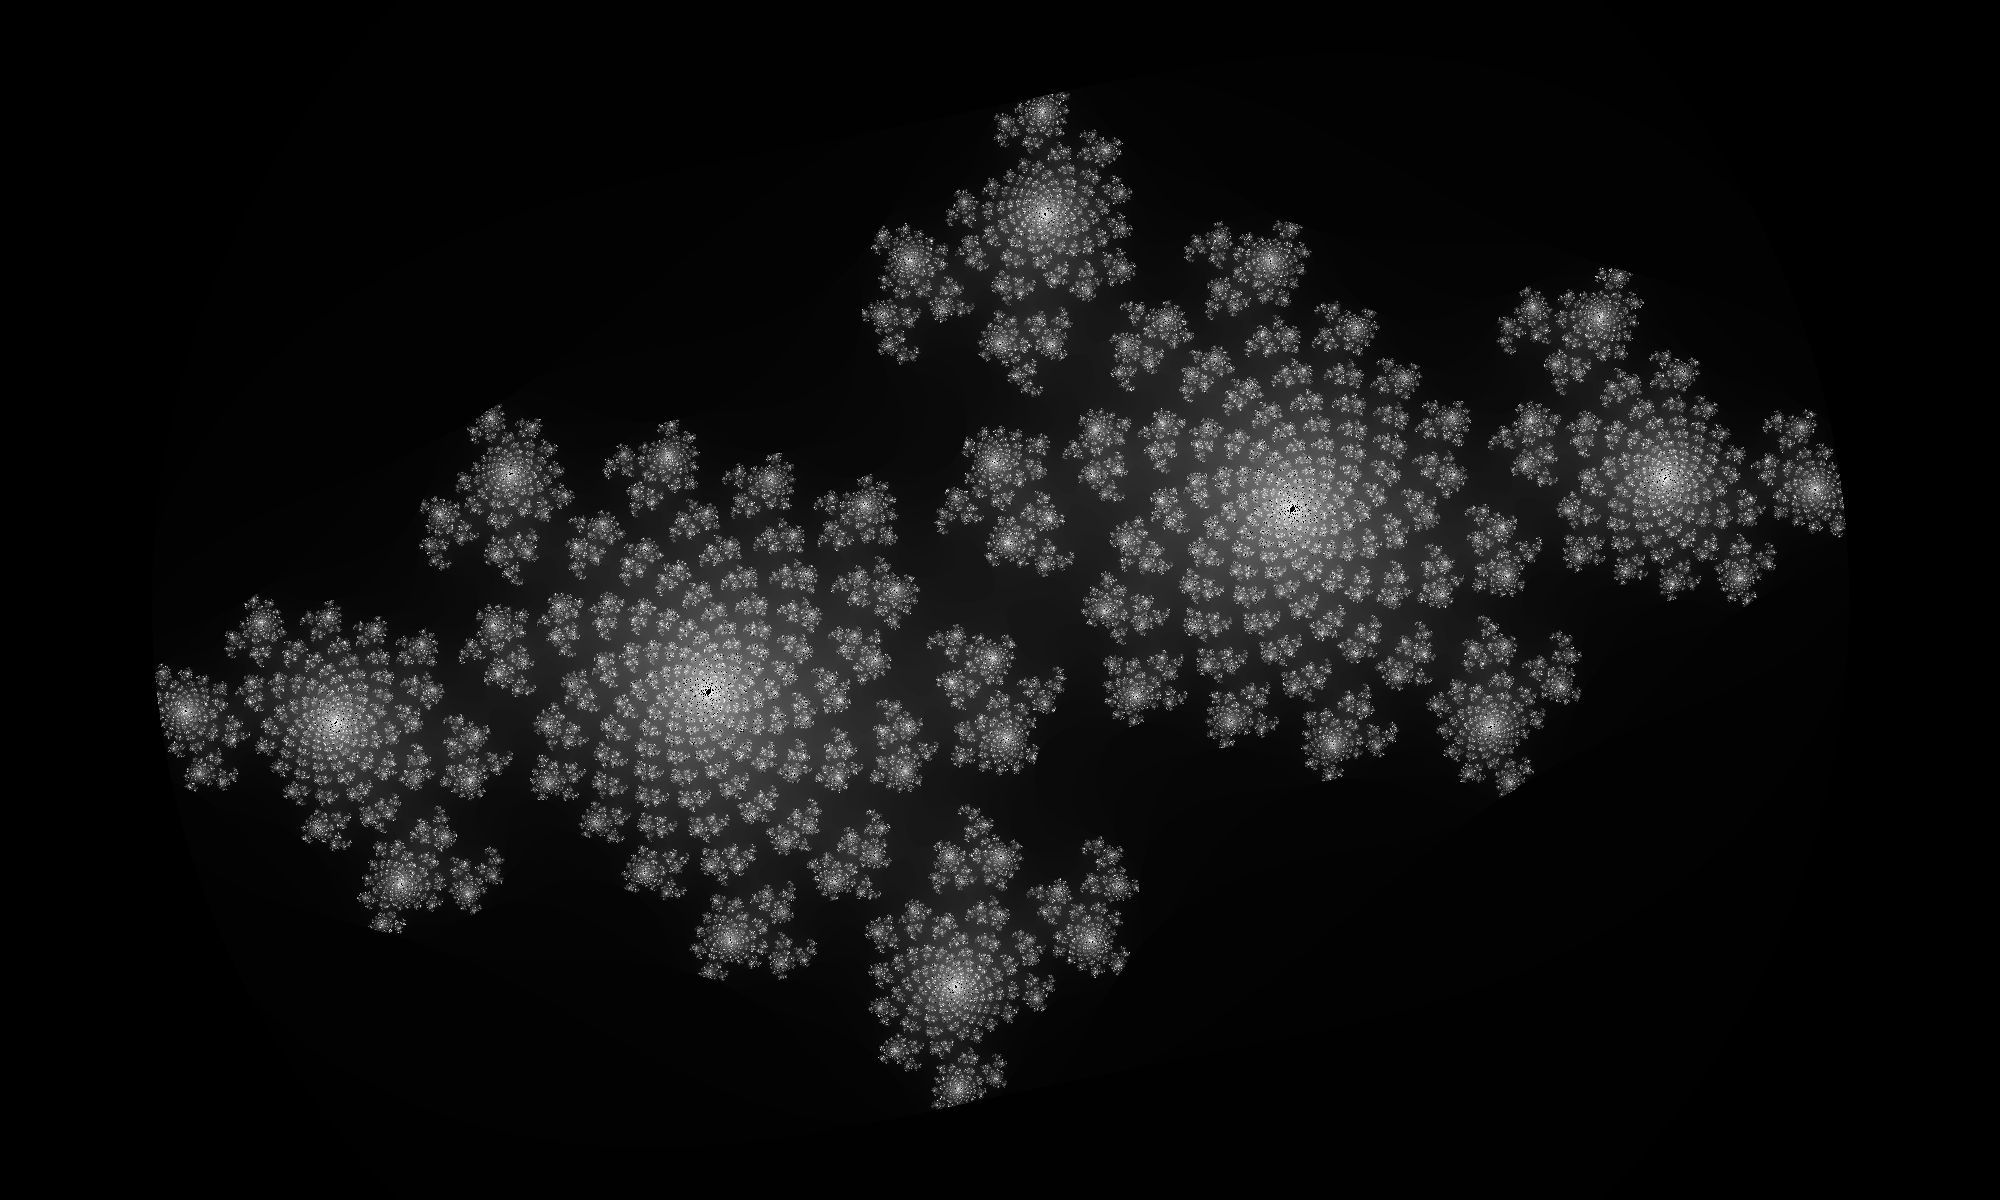

In [22]:
Image.fromarray(m)

In [23]:
%timeit julia_set(2000, 1200, -0.7 + 0.3*1j, 256)
%timeit julia_set_block_fast(2000, 1200, -0.7 + 0.3*1j, 256)
%timeit julia_set_numba_fast(2000, 1200, -0.7 + 0.3*1j, 256)
%timeit julia_set_cython(2000, 1200, -0.7 + 0.3*1j, 256)

1 loop, best of 3: 14 s per loop
1 loop, best of 3: 5.03 s per loop
1 loop, best of 3: 226 ms per loop
1 loop, best of 3: 230 ms per loop


In [24]:
15/0.2

75.0